Shape of the dataset: (4666, 10)

First 5 rows of the dataset:
    CarAge  Mileage     Brand  FuelType Transmission  OwnerCount  EngineSize  \
0      15 70539.73     Honda  Electric       Manual        3.00        1.86   
1      11 72118.01     Honda  Electric    Automatic        4.00        2.46   
2       8 38721.05      Ford    Hybrid       Manual        2.00        1.67   
3       7 33675.66       Kia    Petrol    Automatic        3.00        2.80   
4      19 51562.86  Mercedes    Petrol    Automatic        4.00        2.42   

   Horsepower CarCondition  ResalePrice  
0      116.78         Poor     37380.23  
1      150.06         Fair     58279.18  
2      140.58         Fair     52420.52  
3      157.02         Poor     54195.80  
4      196.91         Fair     57287.51  

Column names:
 Index(['CarAge', 'Mileage', 'Brand', 'FuelType', 'Transmission', 'OwnerCount',
       'EngineSize', 'Horsepower', 'CarCondition', 'ResalePrice'],
      dtype='object')
<class 'pandas.core.frame

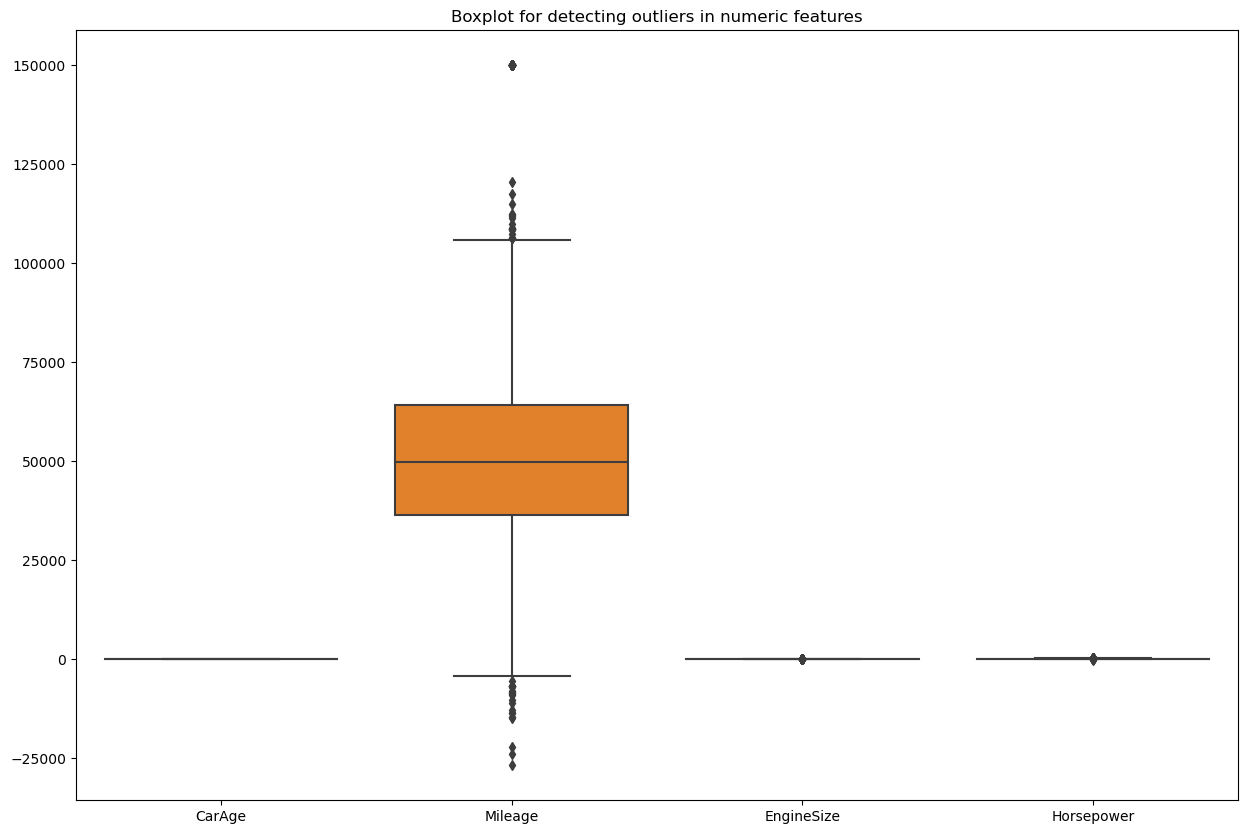

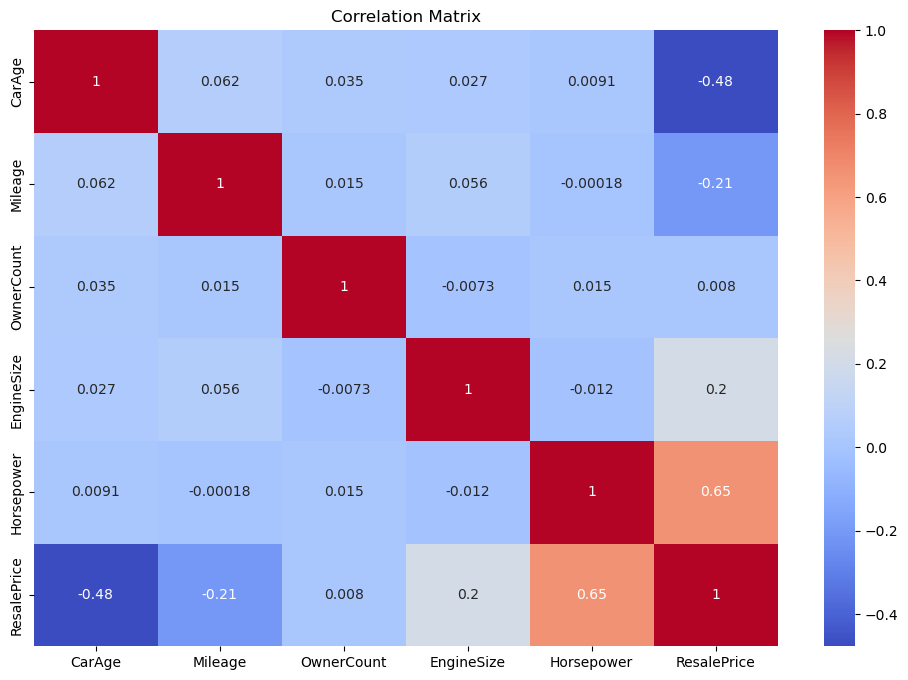

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Importing the necessary library for feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# Display float format setting for better readability
pd.options.display.float_format = '{:.2f}'.format

# Loading the dataset
df = pd.read_csv('used_car_prices_dataset_final.csv')

# Initial Data Exploration
# 1. Understanding the data
print("Shape of the dataset:", df.shape)
print("\nFirst 5 rows of the dataset:\n", df.head())
print("\nColumn names:\n", df.columns)
print("\nData types and null values:\n", df.info())
print("\nSummary statistics:\n", df.describe())
print("\nMissing values count:\n", df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)

# Check for outliers using box plots
plt.figure(figsize=(15,10))
sns.boxplot(data=df[['CarAge', 'Mileage', 'EngineSize', 'Horsepower']])
plt.title('Boxplot for detecting outliers in numeric features')
plt.show()

# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [2]:
# Data Cleaning

# Handling missing values
df['OwnerCount'].fillna(df['OwnerCount'].mode()[0], inplace=True)  # Imputing with mode

# Handling outliers - Removing negative values which are clearly incorrect
df = df[(df['Mileage'] >= 0) & (df['EngineSize'] >= 0) & (df['Horsepower'] >= 0) & (df['ResalePrice'] >= 0)]

# Handling categorical variables using OneHotEncoding for now
df = pd.get_dummies(df, columns=['Brand', 'FuelType', 'Transmission', 'CarCondition'], drop_first=True)

# Feature Scaling
scaler = StandardScaler()
scaled_features = ['CarAge', 'Mileage', 'EngineSize', 'Horsepower']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# Feature Engineering: Adding new features
df['Age_Mileage_Ratio'] = df['CarAge'] / (df['Mileage'] + 1)  # Adding 1 to avoid division by zero
df['Engine_Horsepower_Interaction'] = df['EngineSize'] * df['Horsepower']

# Splitting data into train and test sets
X = df.drop(columns=['ResalePrice'])
y = df['ResalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

(train_mse, train_mae, train_rmse, train_mape, train_r2, test_mse, test_mae, test_rmse, test_mape, test_r2)


(33866655.87099273,
 4662.891642207333,
 5819.506497203412,
 0.09638701228772954,
 0.7678016437668634,
 33969018.67604944,
 4621.054457500132,
 5828.294662767956,
 0.0954085363014997,
 0.7647349842253579)

### The model shows a good fit with a high R² value of around 0.767 for both training and testing sets, indicating that the model explains around 76.7% of the variance in the resale price. The errors are relatively close between the training and testing sets, suggesting that the model generalizes well to unseen data.

## Feature Selection

In [3]:
# Feature Selection: Selecting the top 10 features based on correlation with the target variable
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# Getting the selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print("Selected Features:\n", selected_features)

# Splitting the data into training and testing sets using only selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=31)

# Model Training with selected features
model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train)

# Predictions with selected features
y_train_pred_selected = model_selected.predict(X_train_selected)
y_test_pred_selected = model_selected.predict(X_test_selected)

# Evaluation with selected features
train_mse_selected = mean_squared_error(y_train, y_train_pred_selected)
train_mae_selected = mean_absolute_error(y_train, y_train_pred_selected)
train_rmse_selected = np.sqrt(mean_squared_error(y_train, y_train_pred_selected))
train_mape_selected = mean_absolute_percentage_error(y_train, y_train_pred_selected)
train_r2_selected = r2_score(y_train, y_train_pred_selected)

test_mse_selected = mean_squared_error(y_test, y_test_pred_selected)
test_mae_selected = mean_absolute_error(y_test, y_test_pred_selected)
test_rmse_selected = np.sqrt(mean_squared_error(y_test, y_test_pred_selected))
test_mape_selected = mean_absolute_percentage_error(y_test, y_test_pred_selected)
test_r2_selected = r2_score(y_test, y_test_pred_selected)

(train_mse_selected, train_mae_selected, train_rmse_selected, train_mape_selected, train_r2_selected, test_mse_selected, test_mae_selected, test_rmse_selected, test_mape_selected, test_r2_selected)


Selected Features:
 Index(['CarAge', 'Mileage', 'OwnerCount', 'EngineSize', 'Horsepower',
       'Brand_Kia', 'Brand_Toyota', 'CarCondition_Fair', 'CarCondition_Poor',
       'Engine_Horsepower_Interaction'],
      dtype='object')


(34459345.48430295,
 4712.700074927282,
 5870.208299907505,
 0.09733568571420544,
 0.7637380139094803,
 34349642.72216976,
 4645.6088546821,
 5860.856824916452,
 0.09592197313602681,
 0.7620988314689687)

## Explanation of Metrics:
MSE (Mean Squared Error): Represents the average squared difference between the actual and predicted values. Lower values indicate better performance.
MAE (Mean Absolute Error): Represents the average absolute difference between the actual and predicted values. Lower values are better.
R² (R-squared): Indicates how well the model explains the variance in the target variable. Values closer to 1 indicate a better fit.
RMSE (Root Mean Squared Error):
Definition: RMSE is the square root of the average of the squared differences between the actual and predicted values.

Interpretation:

RMSE penalizes large errors more than smaller ones due to squaring the differences before averaging.
A lower RMSE indicates a better fit of the model to the data.
RMSE is sensitive to outliers, so large errors have a disproportionately large effect.

Usage:

Commonly used to measure the accuracy of regression models.
Helps in comparing different models where the one with the lowest RMSE is typically preferred.

MAPE (Mean Absolute Percentage Error):
Definition: MAPE measures the average of the absolute percentage errors between the actual and predicted values.

Interpretation:

MAPE expresses the error as a percentage, making it easier to understand the relative size of the errors.
It is scale-independent, meaning it can be used to compare forecasts across different datasets.
A lower MAPE indicates better accuracy. For example, a MAPE of 5% means the model's predictions are, on average, 5% off from the actual values.

Limitations:

MAPE can be problematic if the actual values are very close to zero, leading to extremely large or undefined percentage errors.
Not suitable when the data contains zero values since the formula would involve division by zero.

Summary:
RMSE: Focuses on the magnitude of the error, penalizing larger errors more heavily. It provides a clear numeric value that represents the model's prediction accuracy.
MAPE: Provides an error metric in percentage terms, making it easier to understand how far off predictions are in a relative sense.
Both metrics are useful depending on the context. RMSE is preferred when large errors need to be penalized, while MAPE is ideal for understanding errors in relative terms.